In [15]:
import torch
import numpy as np
# import time
# import math
import matplotlib.pyplot as plt
import torch.nn as nn
# import torch.nn.functional as F
import pandas as pd
import torch.utils.data as data

In [16]:
torch.cuda.is_available()

True

In [17]:
device = torch.device("cuda") 
device

device(type='cuda')

In [18]:
def rmsle(y_true,y_pred):
    n = len(y_true)
    msle = np.mean([(np.log(max(y_pred[i],0) + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

In [19]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [21]:
df = pd.read_csv('data.csv')
df_eval_inputs = pd.read_csv('evaluation_data.csv')
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)
train_dataset = data.TensorDataset(torch.from_numpy(train.values[:,2:14].astype(float)),torch.from_numpy(train.values[:,-1].astype(float)))
test_dataset = data.TensorDataset(torch.from_numpy(test.values[:,2:14].astype(float)),torch.from_numpy(test.values[:,-1].astype(float)))
evaluation_dataset = data.TensorDataset(torch.from_numpy(df_eval_inputs.values[:,1:13].astype(float)))
train_data_loader = data.DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=False)
evaluation_data_loader = data.DataLoader(evaluation_dataset, batch_size=len(evaluation_dataset), shuffle=False, drop_last=False)

In [22]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_hidden2, num_hidden3, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.LeakyReLU()
        self.linear2 = nn.Linear(num_hidden, num_hidden2)
        self.act_fn2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(num_hidden2, num_hidden3)
        self.act_fn3 = nn.LeakyReLU()
        self.linear4 = nn.Linear(num_hidden3, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        x = self.act_fn2(x)
        x = self.linear3(x)
        x = self.act_fn3(x)
        x = self.linear4(x)
        return x

In [23]:
model = SimpleClassifier(num_inputs=12, num_hidden=1500, num_hidden2=100, num_hidden3=50, num_outputs=1)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
loss_module = nn.L1Loss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.train() 
loss_progress = []

Epoch: 0, loss: 1.67e+02
Epoch: 1, loss: 1.15e+02
Epoch: 2, loss: 1.21e+02
Epoch: 3, loss: 1.04e+02
Epoch: 4, loss: 1.03e+02
Epoch: 5, loss: 95.3
Epoch: 6, loss: 92.0
Epoch: 7, loss: 1.04e+02
Epoch: 8, loss: 85.9
Epoch: 9, loss: 92.8
Epoch: 10, loss: 94.9
Epoch: 11, loss: 88.7
Epoch: 12, loss: 91.5
Epoch: 13, loss: 1.01e+02
Epoch: 14, loss: 87.0
Epoch: 15, loss: 89.3
Epoch: 16, loss: 1.01e+02
Epoch: 17, loss: 74.7
Epoch: 18, loss: 1.01e+02
Epoch: 19, loss: 77.3
Epoch: 20, loss: 77.1
Epoch: 21, loss: 91.9
Epoch: 22, loss: 81.1
Epoch: 23, loss: 78.6
Epoch: 24, loss: 86.9
Epoch: 25, loss: 83.6
Epoch: 26, loss: 89.6
Epoch: 27, loss: 79.0
Epoch: 28, loss: 76.3
Epoch: 29, loss: 96.5
Epoch: 30, loss: 82.6
Epoch: 31, loss: 79.2
Epoch: 32, loss: 76.4
Epoch: 33, loss: 84.5
Epoch: 34, loss: 81.4
Epoch: 35, loss: 72.2
Epoch: 36, loss: 77.0
Epoch: 37, loss: 85.0
Epoch: 38, loss: 94.0
Epoch: 39, loss: 78.8
Epoch: 40, loss: 70.3
Epoch: 41, loss: 77.8
Epoch: 42, loss: 70.8
Epoch: 43, loss: 72.8
Epoch:

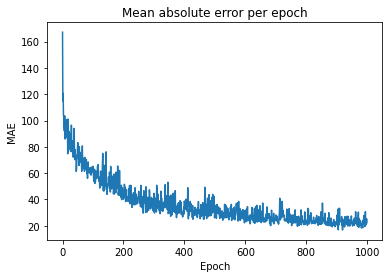

In [24]:
for epoch in range(1000):
    for data_inputs, data_labels in train_data_loader:

        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        preds = model(data_inputs.float())
        preds = preds.squeeze(dim=1) 
        
        loss = loss_module(preds, data_labels.float())
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    loss_progress.append(loss.item())
plt.plot(loss_progress)
plt.title('Mean absolute error per epoch')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.show()

In [25]:
model.eval()

SimpleClassifier(
  (linear1): Linear(in_features=12, out_features=1500, bias=True)
  (act_fn): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=1500, out_features=100, bias=True)
  (act_fn2): LeakyReLU(negative_slope=0.01)
  (linear3): Linear(in_features=100, out_features=50, bias=True)
  (act_fn3): LeakyReLU(negative_slope=0.01)
  (linear4): Linear(in_features=50, out_features=1, bias=True)
)

In [26]:
with torch.no_grad(): 
  data_inputs, data_labels = next(iter(test_data_loader))
  data_inputs = data_inputs.to('cpu')
  data_labels = data_labels.to('cpu')
  model.to('cpu')
  preds = model(data_inputs.float())
  preds = preds.squeeze(dim=1)
  loss = loss_module(preds, data_labels.float())
  rmsle_loss = rmsle(data_labels,preds) 
  # evaluation_data.csv
  data_inputs = next(iter(evaluation_data_loader))[0]
  preds_eval = model(data_inputs.float())
  preds_eval = preds_eval.squeeze(dim=1)

print(f"Mean absolute of the model: {loss:1.3f}")
print(f"rmsle of the model: {rmsle_loss:1.3f}")

Mean absolute of the model: 28.262
rmsle of the model: 0.321
